In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PrModelSIR as pms
import random
from PrModelSIR import ProtectionStrategy

# Parámetros comunes
N = 1000
infection_prob = 0.1
recovery_time = 5
m = 4
runs = 200
network = "BA"
network_ER ="ER"
num_seed_nodes = 4


seed_nodes = random.sample(range(N), num_seed_nodes)


# Diccionario de colores por estrategia
strategy_colors = {
    'No Strategy': 'gray',
    'Random': 'blue',
    'Betweenness': 'green',
    'High Degree': 'red',
    'High Degree Neighbor': 'purple'
}


In [2]:

resources = 50
lambda_number = 4

#Strategies
strategies = {
   "No Strategy": ProtectionStrategy.NO_STRATEGY,
   "Random": ProtectionStrategy.RANDOM,
   "Betweenness": ProtectionStrategy.HIGH_BETWEENNESS,
   "High Degree": ProtectionStrategy.HIGH_DEGREE_NETWORK,
   "High Degree Neighbor": ProtectionStrategy.HIGH_DEGREE_NEIGHBOR
}


# Calcular lambda crítico
model_mmca_ba = pms.PrModelSIR(N, infection_prob, recovery_time, m, resources, seed_nodes ,model=network , protection_strategy= ProtectionStrategy.NO_STRATEGY)
A = np.linalg.eigvals(nx.adjacency_matrix(model_mmca_ba.network).todense()).real
mu = 1 / recovery_time
lambda_max_ba = max(A)
lambda_c_ba = mu / lambda_max_ba

lambda_ = lambda_number * lambda_c_ba  

dataFrame = pd.DataFrame(columns=['network','lambda', 'strategy', 'seed_nodes', 'realization', 'resources', 'attack_rates'])
for i, (strategy_name, strategy_enum) in enumerate(strategies.items()):
    
    for r in range(runs):
            #RELALIZACION INICIAR EL COAUNT PERO SOLO SE APLICA PARA EL PRIMER DETECTADO PUEDE SER EN CUALQUIER PASO TEMPORAL
            count_detected =0 
            model_er = pms.PrModelSIR(N, lambda_, recovery_time, m, resources= resources, seed_nodes = seed_nodes, model=network, protection_strategy=strategy_enum)
            result_er = model_er.step()
            if not result_er.empty:
               attack_rate = result_er['attack_rate'].iloc[-1]
            else:
               attack_rate = 0.0
            #attack_rates.append(result['attack_rate'].iloc[-1])
            dataFrame.loc[len(dataFrame)] = [network,lambda_, strategy_name, str(seed_nodes), r, resources,attack_rate]
dataFrame.to_csv('dataFrame.txt', sep=' ', index=False, float_format="%.6f")


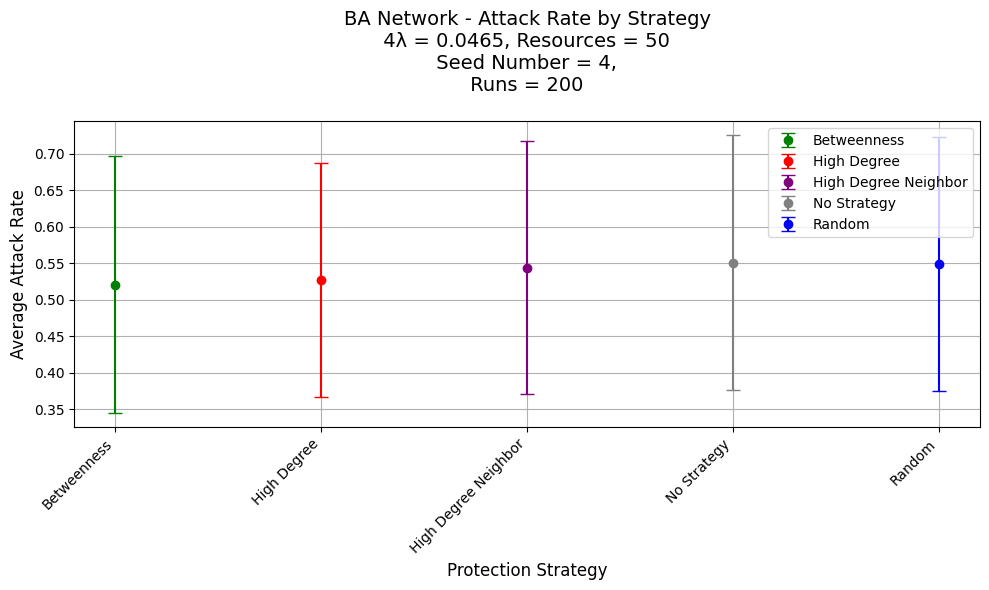

In [3]:
# Valores globales para título
network_type = network.upper()  # Asumiendo que 'model' ya está definido como "BA" o "ER"
lambda_value = round(lambda_, 4)

# Agrupar datos
df_grouped = dataFrame.groupby('strategy')['attack_rates'].agg(['mean', 'std']).reset_index()

# Crear gráfico
fig, ax = plt.subplots(figsize=(10, 6))

# Graficar cada punto con su color
for i, row in df_grouped.iterrows():
    strategy = row['strategy']
    mean = row['mean']
    std = row['std']
    color = strategy_colors.get(strategy, 'black')  # Default color if missing
    ax.errorbar(i, mean, yerr=std, fmt='o', color=color, label=strategy, capsize=5)

# Ajustes de ejes
ax.set_xticks(range(len(df_grouped)))
ax.set_xticklabels(df_grouped['strategy'], rotation=45, ha='right')
ax.set_xlabel('Protection Strategy', fontsize=12)
ax.set_ylabel('Average Attack Rate', fontsize=12)
ax.set_title(f'{network_type} Network - Attack Rate by Strategy\n {lambda_number}λ = {lambda_value}, Resources = {resources} \n Seed Number = {num_seed_nodes}, \n Runs = {runs} \n' , fontsize=14)
ax.grid(True)
ax.tick_params(axis='both', labelsize=10)

# Evitar duplicados en leyenda
handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys())

plt.tight_layout()
plt.show()


In [4]:


model_mmca_er = pms.PrModelSIR(N, infection_prob, recovery_time, m, resources, seed_nodes ,model=network_ER , protection_strategy= ProtectionStrategy.NO_STRATEGY)
B = np.linalg.eigvals(nx.adjacency_matrix(model_mmca_er.network).todense()).real
mu = 1 / recovery_time
lambda_max_er = max(B)
lambda_c_er = mu / lambda_max_er
lambda_er = lambda_number * lambda_c_er
#lambda_er = 0.01

dataFrame_er= pd.DataFrame(columns=['network','lambda', 'strategy', 'seed_nodes', 'realization', 'resources', 'attack_rates'])
row_er = 0
for i, (strategy_name, strategy_enum) in enumerate(strategies.items()):
    for r in range(runs):
            model_er = pms.PrModelSIR(N, lambda_er, recovery_time, m, resources= resources, seed_nodes = seed_nodes, model=network_ER, protection_strategy=strategy_enum)
            result_er = model_er.step()
            #attack_rates.append(result['attack_rate'].iloc[-1])
            dataFrame_er.loc[row_er] = [network_ER,lambda_, strategy_name, str(seed_nodes), r, resources, result_er['attack_rate'].iloc[-1] ]
            row_er += 1
dataFrame_er.to_csv('dataFrame_er.txt', sep=' ', index=False)
    

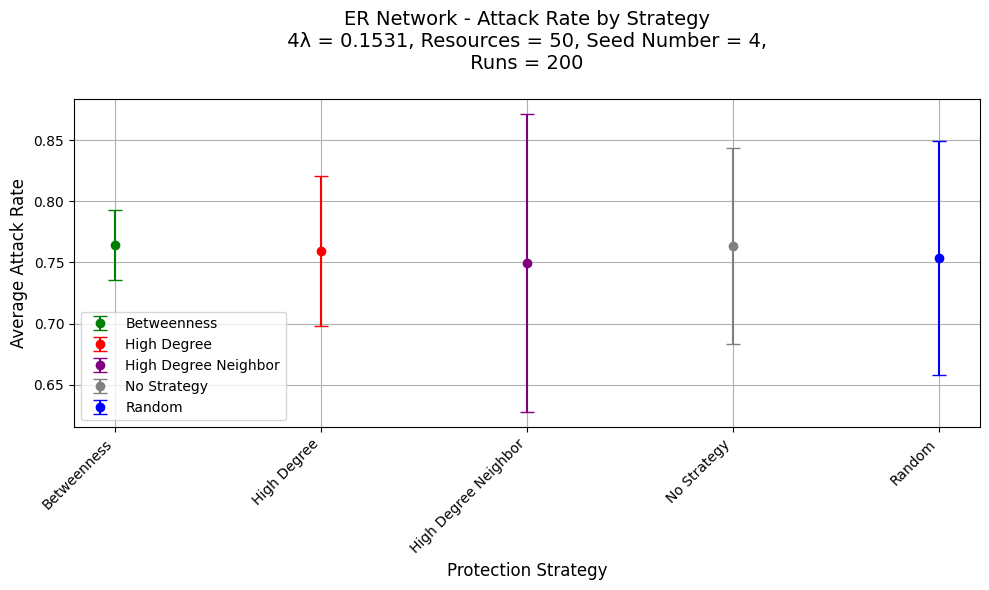

In [5]:
network_type_er = network_ER.upper() 
lambda_value_er = round(lambda_er, 4)

# Agrupar datos
df_grouped_er = dataFrame_er.groupby('strategy')['attack_rates'].agg(['mean', 'std']).reset_index()

# Crear gráfico
fig_er, ax_er = plt.subplots(figsize=(10, 6))

# Graficar cada punto con su color
for i, row in df_grouped_er.iterrows():
    strategy = row['strategy']
    mean = row['mean']
    std = row['std']
    color = strategy_colors.get(strategy, 'black')  # Default color if missing
    ax_er.errorbar(i, mean, yerr=std, fmt='o', color=color, label=strategy, capsize=5)

# Ajustes de ejes
ax_er.set_xticks(range(len(df_grouped)))
ax_er.set_xticklabels(df_grouped['strategy'], rotation=45, ha='right')
ax_er.set_xlabel('Protection Strategy', fontsize=12)
ax_er.set_ylabel('Average Attack Rate', fontsize=12)
ax_er.set_title(f'{network_type_er} Network - Attack Rate by Strategy\n {lambda_number}λ = {lambda_value_er}, Resources = {resources}, Seed Number = {num_seed_nodes}, \n Runs = {runs} \n' , fontsize=14)
ax_er.grid(True)
ax_er.tick_params(axis='both', labelsize=10)

# Evitar duplicados en leyenda
handles, labels = ax_er.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax_er.legend(unique.values(), unique.keys())

plt.tight_layout()
plt.show()
